In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy import interpolate

In [ ]:
# choose whatever backend
# %matplotlib 

# The tl;dr version, lightly commented

In [ ]:
# read in data - for final version remove the cropping
raw=mne.io.read_raw_fif('camcan/sub-CC110033/meg/sub-CC110033_ses-rest_task-rest.fif')
raw.crop(tmax=60).pick_types(meg='mag')
raw.load_data()

# filter data and perform ICA
n_components = 20
filt_raw = raw.copy().filter(l_freq=1,h_freq=None)
ica=mne.preprocessing.ICA(n_components=n_components,max_iter='auto')
ica.fit(filt_raw)

# extract magnetometer positions
data_picks, pos, merge_channels, names, ch_type, sphere, clip_origin = \
   mne.viz.topomap._prepare_topomap_plot(ica, 'mag')

# Extract locations of each channel and convert to spherical coordinates
channel_locations3d = np.zeros([len(mags),3])
for i in np.arange(0,len(mags)):
    tmp=channel_info[i]
    channel_locations3d[i,:]=tmp['loc'][0:3] # 'loc' has 12 elements, the location plus a 3x3 orientation matrix

channel_locations_3d_spherical = np.transpose(cart2sph(channel_locations3d[:,0],channel_locations3d[:,1],channel_locations3d[:,2]))

TH=channel_locations_3d_spherical[:,1]
PHI=channel_locations_3d_spherical[:,2]

# project the spherical locations to a plane
# this calculates a new R for each coordinate, based on PHI
# then transform the projection to Cartesian coordinates
channel_locations_2d=np.zeros([len(mags),2])
newR=np.zeros((len(mags),))
newR = 1 - PHI/np.pi*2
channel_locations_2d=np.transpose(pol2cart(newR,TH))
X=channel_locations_2d[:,0]
Y=channel_locations_2d[:,1]

# use ConvexHull to get the sensor indices around the edges, and scale their radii to a unit circle
hull = ConvexHull(channel_locations_2d)
Border=hull.vertices
Dborder = 1/newR[Border]

# Define an interpolation function of the TH coordinate to define a scaling factor for R
FuncTh=np.hstack([TH[Border]-2*np.pi, TH[Border], TH[Border]+2*np.pi]).reshape((57,));
funcD=np.hstack((Dborder,Dborder,Dborder))
finterp = interpolate.interp1d(FuncTh,funcD);
D = finterp(TH)

# Apply the scaling to every radii coordinate and transform back to Cartesian coordinates
newerR=np.zeros((102,))
for i in np.arange(0,102):
    newerR[i] = min(newR[i]*D[i],1)
[Xnew,Ynew]=pol2cart(newerR,TH)
pos_new=np.transpose(np.vstack((Xnew,Ynew)))

# create a circular outline without nose and ears, and get coordinates
outlines_new = make_head_outlines_new(np.array([0,0,0,1]),pos_new,'head',(0,0))
outline_coords=np.array(outlines_new['head'])

# masking the outline only works on some matplotlib backends, so I've commented it out
for comp in np.arange(0,n_components,1):
    data = np.dot(camcan_ica.mixing_matrix_[:,comp].T,camcan_ica.pca_components_[:camcan_ica.n_components_])
    mne.viz.plot_topomap(data,pos_new,sensors=False,outlines=outlines_new,extrapolate='head',sphere=[0,0,0,1],contours=0,res=128)
    #plt.plot(outline_coords[0,:],outline_coords[1,:],'white')
    

# requisite function declarations

In [2]:
# function to transform Cartesian coordinates to spherical coordinates
# theta = azimuth
# phi = elevation

def cart2sph(x, y, z):
    xy = np.sqrt(x*x + y*y)
    r = np.sqrt(x*x + y*y + z*z)
    theta = np.arctan2(y,x)
    phi = np.arctan2(z,xy)
    return r, theta, phi
# function to transform 2d polar coordinates to Cartesian
def pol2cart(rho,phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x,y
# function to transform 2d Cartesian coodinates to polar coordinates
def cart2pol(x,y):
    r = np.sqrt(x*x + y*y)
    theta = np.arctan2(y,x)
    return r,theta
# re-write of the MNE python function make_head_outlines() without the nose and ears, with expansion 
# of the outline to 1.01 

def make_head_outlines_new(sphere, pos, outlines, clip_origin):
    """Check or create outlines for topoplot."""
    assert isinstance(sphere, np.ndarray)
    x, y, _, radius = sphere
    del sphere

    ll = np.linspace(0, 2 * np.pi, 101)
    head_x = np.cos(ll) * radius*1.01 + x
    head_y = np.sin(ll) * radius*1.01 + y
    dx = np.exp(np.arccos(np.deg2rad(12)) * 1j)
    dx, dy = dx.real, dx.imag
    
    outlines_dict = dict(head=(head_x, head_y))
    
    # Make the figure encompass slightly more than all points
    mask_scale = 1.
    # We probably want to ensure it always contains our most
    # extremely positioned channels, so we do:
    mask_scale = max(
            mask_scale, np.linalg.norm(pos, axis=1).max() * 1.01 / radius)
    
    outlines_dict['mask_pos'] = (mask_scale * head_x, mask_scale * head_y)
    clip_radius = radius * mask_scale
    outlines_dict['clip_radius'] = (clip_radius,) * 2
    outlines_dict['clip_origin'] = clip_origin      
    
    outlines = outlines_dict
    
    return outlines

# The long version, heavily commented, with debug plots throughout

In [3]:
# read in data - must be loaded for ica
# limit to the first 60s and magnetometers only, so it loads and processes faster
camcan=mne.io.read_raw_fif('camcan/sub-CC110033/meg/sub-CC110033_ses-rest_task-rest.fif')
camcan.crop(tmax=60).pick_types(meg='mag')
camcan.load_data()

Opening raw data file camcan/sub-CC110033/meg/sub-CC110033_ses-rest_task-rest.fif...


<ipython-input-3-cd014785d096>:3: RuntimeWarning: This filename (camcan/sub-CC110033/meg/sub-CC110033_ses-rest_task-rest.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  camcan=mne.io.read_raw_fif('camcan/sub-CC110033/meg/sub-CC110033_ses-rest_task-rest.fif')


    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 67000 ... 640999 =     67.000 ...   640.999 secs
Ready.
Reading 0 ... 60000  =      0.000 ...    60.000 secs...


<Raw | sub-CC110033_ses-rest_task-rest.fif, 102 x 60001 (60.0 s), ~52.9 MB, data loaded>

In [4]:
# filter data to prepare for ica
filt_camcan = camcan.copy().filter(l_freq=1,h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 sec)



In [5]:
# fit the ica
camcan_ica=mne.preprocessing.ICA(n_components=20,max_iter='auto')
camcan_ica.fit(filt_camcan)

Fitting ICA to data using 102 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.2s.


<ICA | raw data decomposition, fit (fastica): 60001 samples, 20 components, channels used: "mag">

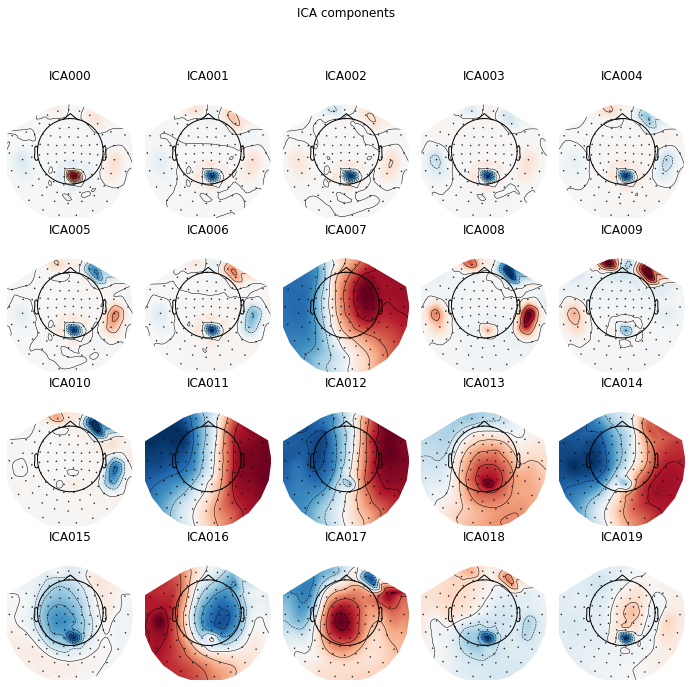

[<MNEFigure size 702x696.24 with 20 Axes>]

In [6]:
camcan_ica.plot_components(ch_type='mag')

In [ ]:
# if you want to see all the attributes...
camcan_ica.__dict__

In [13]:
# choose a component number
comp=16

In [14]:
# extract the component topomap data for the selected component
data = np.dot(camcan_ica.mixing_matrix_[:, comp].T,
                  camcan_ica.pca_components_[:camcan_ica.n_components_])

In [15]:
# this command extracts the positions for the magnetometers
data_picks, pos, merge_channels, names, ch_type, sphere, clip_origin = \
   mne.viz.topomap._prepare_topomap_plot(camcan_ica, 'mag')

In [20]:
# here are the sensor numbers for just the mags, if you didn't filter the mags out when you did the ica
mags=mne.pick_types(filt_camcan.info,meg='mag')
# get the component data for just the mags
data_mags=data[mags]
np.shape(data_mags)

(102,)

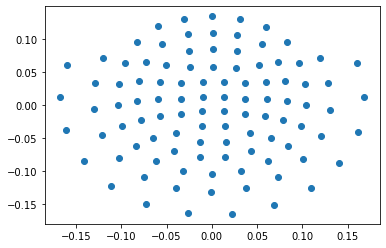

In [16]:
plt.scatter(pos[:,0],pos[:,1])

In [18]:
# extract the channel info 
channel_info=np.array(filt_camcan.info['chs'])

In [21]:
# initialize an array to hold the channel location coordinates for the mags
channel_locations3d = np.zeros([len(mags),3])

In [22]:
# Extract the channel locations from the complicated channel info structure - this is not very pythonic
# I tried to avoid a loop, but I gave up
for i in np.arange(0,len(mags)):
  tmp=channel_info[i]
  channel_locations3d[i,:]=tmp['loc'][0:3] # 'loc' has 12 elements, the location plus a 3x3 orientation matrix

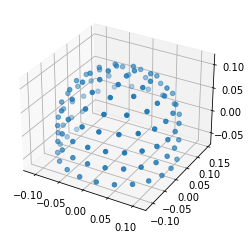

In [23]:
# confirming I actully got real sensor locations
fig=plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(channel_locations3d[:,0],channel_locations3d[:,1],channel_locations3d[:,2])
plt.show()

In [ ]:
# write out the channel locations for testing in matlab
np.savetxt('channel_locations3d.txt',channel_locations3d,)

In [24]:
# convert the sensor locations to spherical coordinates
# theta = azimuth
# phi = elevation
# output is (rho, theta, phi)
channel_locations_3d_spherical = np.transpose(cart2sph(channel_locations3d[:,0],channel_locations3d[:,1],channel_locations3d[:,2]))

In [25]:
# assign some variables to make things easier
R3=channel_locations_3d_spherical[:,0]
TH=channel_locations_3d_spherical[:,1]
PHI=channel_locations_3d_spherical[:,2]

In [26]:
# project the spherical locations to a plane
# this calculates a new R for each coordinate, based on PHI
# then transform the projection to Cartesian coordinates
channel_locations_2d=np.zeros([len(mags),2])
newR=np.zeros((len(mags),))
newR = 1 - PHI/np.pi*2
channel_locations_2d=np.transpose(pol2cart(newR,TH))

In [27]:
# more shortcut variables
X=channel_locations_2d[:,0]
Y=channel_locations_2d[:,1]

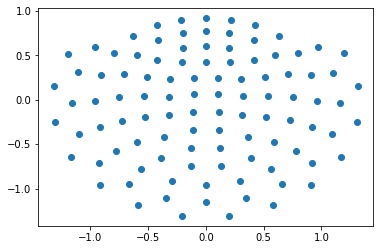

In [28]:
# plot the simple projection, which is not a circle
plt.scatter(X,Y)
plt.show()

In [29]:
# use ConvexHull to get the sensor indices around the edges
hull = ConvexHull(channel_locations_2d)
Border=hull.vertices

In [30]:
# Dborder is how much you have to scale each border point by to put it on a unit circle
Dborder = 1/newR[Border]

In [31]:
# We'll make a list of angle values for every border point's theta coordinate along 
# with the theta coord plus and minus 2pi
FuncTh=np.hstack([TH[Border]-2*np.pi, TH[Border], TH[Border]+2*np.pi]).reshape((57,));

In [32]:
# Just stacking the required scaling for each theta vlue
funcD=np.hstack((Dborder,Dborder,Dborder))

In [33]:
# calculate an interppolation function to find out how much to stretch the radius for 
# any angle theta
finterp = interpolate.interp1d(FuncTh,funcD);

In [34]:
# get the radius scaling value for every theta coord in the entire montage
D = finterp(TH)

In [35]:
# again, not very pythonic, but I suck. 
# find a newer value of R after applying the radius scaling to every sensor location
newerR=np.zeros((102,))
for i in np.arange(0,102):
    newerR[i] = min(newR[i]*D[i],1)

In [36]:
# put those new coords back into Cartesian coordinates
[Xnew,Ynew]=pol2cart(newerR,TH)

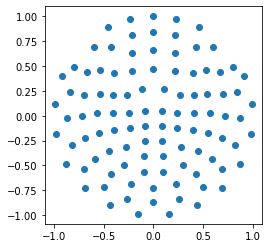

In [45]:
# plot to confirm we indeed have a circle
fig=plt.figure()
ax=fig.add_subplot(111)
plt.plot(Xnew,Ynew,'o')
ax.set_aspect('equal')
plt.show()

In [46]:
# assign these new sensor positions to pos_new
pos_new=np.transpose(np.vstack((Xnew,Ynew)))

In [47]:
# in order to crop the head to a circle, we'll need to crete an outline. But we don't need 
# the nose and ears like the normal MNE python head outline
outlines_new = make_head_outlines_new(np.array([0,0,0,1]),pos_new,'head',(0,0))

In [48]:
# these are the actual coordinates for the circular outline. You can't get the topomap plot
# without the black outline but with proper masking. A hack is to draw a while line over the black
# outline. But we need the coordinates.
outline_coords=np.array(outlines_new['head'])

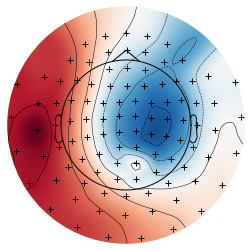

(<matplotlib.image.AxesImage at 0x7fbb9e1c3760>,
 <matplotlib.contour.QuadContourSet at 0x7fbb9e1c3af0>)

In [49]:
# plot a topomap with the original positions
mne.viz.plot_topomap(data,pos,sensors='k+')

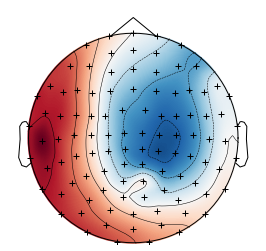

(<matplotlib.image.AxesImage at 0x7fbb9e245be0>,
 <matplotlib.contour.QuadContourSet at 0x7fbb9e245f70>)

In [50]:
# here's a plot of the new sensor locations with the standard head outlines, scaled to a unit circle
outlines=mne.viz.topomap._make_head_outlines(np.array([0,0,0,1]),pos_new,'head',(0,0))
mne.viz.plot_topomap(data,pos_new,sensors='k+',outlines=outlines,extrapolate='head',sphere=[0,0,0,1])

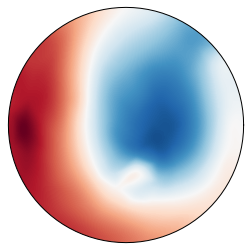

In [68]:
# here's a plot of the topomap with the outlines masked, with no contours and higher resolution
# note that masking of the outline works on some but not all matplotlib backends.
fig=plt.figure()
ax=fig.add_subplot(111)
im, cn = mne.viz.plot_topomap(data,pos_new,sensors=False,axes=ax, outlines=outlines_new,extrapolate='head',sphere=[0,0,0,1],contours=0,res=128)
ax.plot(outline_coords[0,:],outline_coords[1,:],'w')
plt.show()